In [1]:
cd wrkDir/FPFS2/sim

/lustre/work/xiangchong.li/work/FPFS2/sim


In [2]:
%pylab inline
import gc
import galsim
from fpfs import fpfsBase
import imgSimutil
import numpy as np
import astropy.io.fits as pyfits
import numpy.lib.recfunctions as rfn
from astropy.table import Table,vstack,hstack

pltDir='plot/histograms/'
if not os.path.isdir(pltDir):
    os.mkdir(pltDir)
vdir='outcome-var7em3'

Populating the interactive namespace from numpy and matplotlib


In [16]:
def selCat(catalog):
    ngrid=64
    ngalR=100
    catalog['centDist'] =   ((catalog['base_SdssCentroid_y']%ngrid-ngrid/2)**2.+
                    (catalog['base_SdssCentroid_x']%ngrid-ngrid/2)**2.)

    catalog['centDist'] =   np.sqrt(catalog['centDist'])
    catalog             =   catalog[(catalog['centDist']<5.)]

    # First, keep only detections that are the closest to the grid point
    # Get sorted index by grid index and grid distance
    # Add a gridIndex column instead of using the index column, for compatibility
    catalog['ipos']     =   (catalog['base_SdssCentroid_y']//ngrid)*ngalR +(catalog['base_SdssCentroid_x']//ngrid)
    catalog['ipos']     =   catalog['ipos'].astype(np.int)
    inds        =   np.lexsort([catalog['centDist'], catalog['ipos']])
    catalog     =   catalog[inds]
    inds_unique =   np.unique(catalog['ipos'], return_index=True)[1]
    return catalog[inds_unique]

In [30]:
fatAll=[]
datAll=[]
for igroup in range(7):
    for ii in range(2):
        ifield=igroup*250+ii
        fname0=os.path.join(vdir,'fpfs-rcut16-psf60-%d/src%04d-g1-0000.fits' %(igroup,ifield))
        fat=Table.read(fname0)
        fname=os.path.join(vdir,'src-psf60-%d/src%04d-g1-0000.fits' %(igroup,ifield))
        dat=Table.read(fname)
        dat=selCat(dat)
        dat=hstack([fat[dat['ipos']],dat])
        datAll.append(dat)
        del dat,fname
        del fat,fname0
        gc.collect()
        
datAll=vstack(datAll)

In [53]:
C1=500.
ell1=fpfsBase.fpfsM2E(datAll,C1,rev=True)
w1=1. / (1 + C1/datAll['fpfs_M00'])
C2=2000.
ell2=fpfsBase.fpfsM2E(datAll,C2,rev=True)
w2=1. / (1 + C2/datAll['fpfs_M00'])
snr=datAll['modelfit_CModel_initial_instFlux']/datAll['modelfit_CModel_initial_instFluxErr']

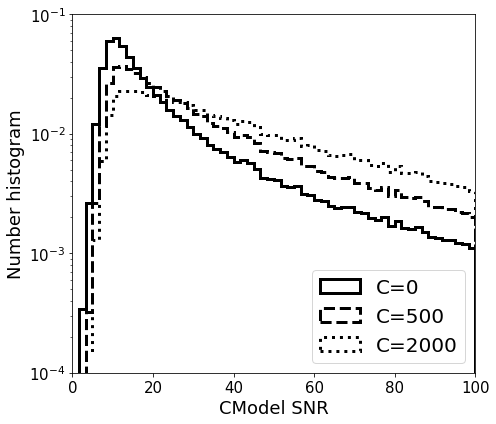

In [56]:
plt.close()
fig=plt.figure(figsize=(7,6))
ax=fig.add_subplot(1,1,1)
ax.hist(snr,bins=60,range=(0.,100),density=True,color='black',histtype='step',\
        linewidth=3.,ls='-',label=r'C=0')
ax.hist(snr,bins=60,range=(0.,100),weights=w1,density=True,color='black',histtype='step',\
        linewidth=3.,ls='--',label=r'C=500')
ax.hist(snr,bins=60,range=(0.,100),weights=w2,density=True,color='black',histtype='step',\
        linewidth=3.,ls=':',label=r'C=2000')
ax.set_xlabel(r'CModel SNR')
ax.set_ylabel(r'Number histogram')
ax.legend(loc='lower right')
ax.set_xlim(0,100)
ax.set_ylim(1e-4,1e-1)
ax.set_yscale('log')
plt.tight_layout()
fig.savefig(os.path.join(pltDir,'histCModel.png'))
fig.savefig(os.path.join(pltDir,'histCModel.pdf'))